In [11]:
from tensorflow.keras.preprocessing.image import load_img
import tensorflow.keras.callbacks

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

import numpy as np
import matplotlib.pyplot as plt

import sys
import time

import os
import io
import tensorflow as tf

In [12]:
# Dictionary for storing the results
model_data = {
    'VGG1': {
        'Trainingtime': None,
        'Trainingloss': None,
        'Trainingaccuracy': None,
        'Testingaccuracy': None,
        'Numberofmodelparameters': None
    },
    'VGG3': {
        'Trainingtime': None,
        'Trainingloss': None,
        'Trainingaccuracy': None,
        'Testingaccuracy': None,
        'Numberofmodelparameters': None
    },
    'VGG3DA': {
        'Trainingtime': None,
        'Trainingloss': None,
        'Trainingaccuracy': None,
        'Testingaccuracy': None,
        'Numberofmodelparameters': None
    },
    'VGG16TL': {
        'Trainingtime': None,
        'Trainingloss': None,
        'Trainingaccuracy': None,
        'Testingaccuracy': None,
        'Numberofmodelparameters': None
    }
}


# Utility Functions
### Creating model creators

In [13]:
def VGG1():
	# define cnn model
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

def VGG3():
	# define cnn model
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# VGG3 with Data Augmentation
def VGG3_DA():
	# define cnn model
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# define cnn transfer learning with VGG16 model
def VGG16_TL():
	# load model
	model = VGG16(include_top=False, input_shape=(224, 224, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(1, activation='sigmoid')(class1)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

In [14]:
# FOR VGG1, VGG3
def prepare_iterators_VGG():
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = datagen.flow_from_directory('dataset_Rabbit_vs_Squirrel/train/',
		class_mode='binary', batch_size=32, target_size=(200, 200))
	test_it = datagen.flow_from_directory('dataset_Rabbit_vs_Squirrel/test/',
		class_mode='binary', batch_size=32, target_size=(200, 200))
	return train_it, test_it

def prepare_iterators_VGG3_DA():
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
	# prepare iterators
	train_it = datagen.flow_from_directory('dataset_Rabbit_vs_Squirrel/train/',
		class_mode='binary', batch_size=32, target_size=(200, 200))
	test_it = datagen.flow_from_directory('dataset_Rabbit_vs_Squirrel/test/',
		class_mode='binary', batch_size=32, target_size=(200, 200))
	return train_it, test_it

def prepare_iterators_TL():
	#create data generator
	datagen = ImageDataGenerator(featurewise_center=True)
	datagen.mean = [123.68, 116.779, 103.939]

	# prepare iterator
	train_it = datagen.flow_from_directory('dataset_Rabbit_vs_Squirrel/train/', class_mode='binary', batch_size=32, target_size=(224, 224))
	test_it = datagen.flow_from_directory('dataset_Rabbit_vs_Squirrel/test/', class_mode='binary', batch_size=32, target_size=(224, 224))
	return train_it, test_it

### Function to analyze outputs

In [15]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
    # create figure and axes objects
    fig, axs = plt.subplots(2, 1, figsize=(8, 8))
    plt.subplots_adjust(hspace=0.5)

    # plot loss
    axs[0].set_title('Cross Entropy Loss')
    axs[0].plot(history.history['loss'], color='blue', label='train')
    axs[0].plot(history.history['val_loss'], color='orange', label='test')
    axs[0].set_ylabel('Loss')
    axs[0].legend(loc='upper right')

    # plot accuracy
    axs[1].set_title('Classification Accuracy')
    axs[1].plot(history.history['accuracy'], color='blue', label='train')
    axs[1].plot(history.history['val_accuracy'], color='orange', label='test')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend(loc='lower right')

    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    # plt.savefig(filename + '_plot.png')
    plt.show()

# Creating models and iterators

In [16]:
model_VGG1 = VGG1()
model_VGG3 = VGG3()
# Iterators for VGG 1, VGG3
train_it, test_it = prepare_iterators_VGG()


# VGG 3 with Data Augmentation
model_VGG3_DA = VGG3_DA()
train_it_da, test_it_da = prepare_iterators_VGG3_DA()

# VGG16 Transfer Learning
model_VGG16_TL = VGG16_TL()
train_it_tl, test_it_tl = prepare_iterators_TL()

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


# VGG1

In [17]:
# Returns the trained model and accuracy
def fit_model_evaluate(model, train_it, test_it):
	# fit model
	tb_callback = tensorflow.keras.callbacks.TensorBoard(log_dir="logs/VGG1", histogram_freq=1)
	history = model.fit(train_it, steps_per_epoch=len(train_it), validation_data=test_it, validation_steps=len(test_it), epochs=20,verbose=1, callbacks=[tb_callback])

	return history, train_it, test_it


Epoch 1/20


2023-04-19 18:46:56.583895: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


5/5 [==============================] - 17s 4s/step - loss: 3.0472 - accuracy: 0.5250 - val_loss: 0.6831 - val_accuracy: 0.6250
Epoch 2/20
5/5 [==============================] - 19s 4s/step - loss: 0.8140 - accuracy: 0.5125 - val_loss: 0.7015 - val_accuracy: 0.5000
Epoch 3/20
5/5 [==============================] - 22s 5s/step - loss: 0.6968 - accuracy: 0.6313 - val_loss: 0.6497 - val_accuracy: 0.6250
Epoch 4/20
5/5 [==============================] - 17s 4s/step - loss: 0.6923 - accuracy: 0.5063 - val_loss: 0.6387 - val_accuracy: 0.6500
Epoch 5/20
5/5 [==============================] - 20s 5s/step - loss: 0.6499 - accuracy: 0.6062 - val_loss: 0.6869 - val_accuracy: 0.6250
Epoch 6/20
5/5 [==============================] - 16s 4s/step - loss: 0.7223 - accuracy: 0.5125 - val_loss: 0.6694 - val_accuracy: 0.6250
Epoch 7/20
5/5 [==============================] - 15s 4s/step - loss: 0.5858 - accuracy: 0.6687 - val_loss: 0.9890 - val_accuracy: 0.3750
Epoch 8/20
5/5 [=============================

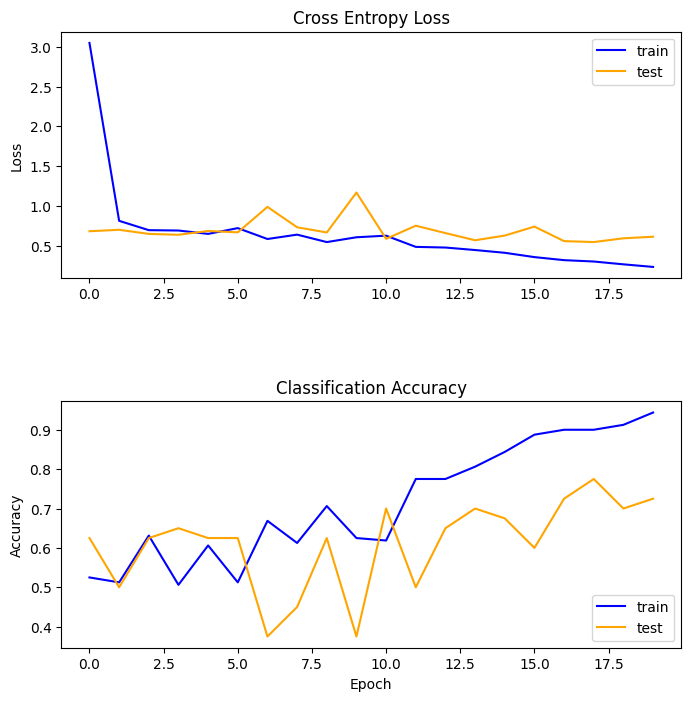

> 72.500


In [18]:
begin_time = time.time()
history, train_it, test_it = fit_model_evaluate(model_VGG1, train_it, test_it)
end_time = time.time()

# evaluate model
summarize_diagnostics(history)
# accuracy
_, acc = model_VGG1.evaluate(test_it, steps=len(test_it), verbose=0)
print('> %.3f' % (acc * 100.0))


In [19]:
training_loss=history.history['loss'][-1]
training_acc=history.history['accuracy'][-1]
testing_acc=history.history['val_accuracy'][-1]
number_of_parameters=model_VGG1.count_params()
training_time= end_time - begin_time

print("Training Loss: ", training_loss)
print("Training Accuracy: ", training_acc)
print("Testing Accuracy: ", testing_acc)
print("Number of Parameters: ", number_of_parameters)
print("Training Time: ", training_time)

model_data['VGG1']['Trainingtime'] = (training_time)
model_data['VGG1']['Trainingloss'] = (training_loss)
model_data['VGG1']['Trainingaccuracy'] = (training_acc)
model_data['VGG1']['Testingaccuracy'] = (testing_acc)
model_data['VGG1']['Numberofmodelparameters'] = (number_of_parameters)


Training Loss:  0.2352965772151947
Training Accuracy:  0.9437500238418579
Testing Accuracy:  0.7250000238418579
Number of Parameters:  40961153
Training Time:  326.0308518409729


# VGG3

In [20]:
# Returns the trained model and accuracy
def fit_model_evaluate(model, train_it, test_it):
	# fit model
	tb_callback = tensorflow.keras.callbacks.TensorBoard(log_dir="logs/VGG3", histogram_freq=1)
	history = model.fit(train_it, steps_per_epoch=len(train_it), validation_data=test_it, validation_steps=len(test_it), epochs=20,verbose=1, callbacks=[tb_callback])

	return history, train_it, test_it


Epoch 1/20
5/5 [==============================] - 7s 1s/step - loss: 1.1435 - accuracy: 0.5063 - val_loss: 0.7026 - val_accuracy: 0.6250
Epoch 2/20
5/5 [==============================] - 6s 1s/step - loss: 0.7348 - accuracy: 0.5312 - val_loss: 0.8760 - val_accuracy: 0.3750
Epoch 3/20
5/5 [==============================] - 5s 1s/step - loss: 0.7308 - accuracy: 0.4500 - val_loss: 0.6450 - val_accuracy: 0.6500
Epoch 4/20
5/5 [==============================] - 5s 1s/step - loss: 0.6375 - accuracy: 0.6750 - val_loss: 0.7320 - val_accuracy: 0.3750
Epoch 5/20
5/5 [==============================] - 5s 1s/step - loss: 0.6293 - accuracy: 0.5750 - val_loss: 0.6221 - val_accuracy: 0.6250
Epoch 6/20
5/5 [==============================] - 6s 1s/step - loss: 0.6006 - accuracy: 0.6687 - val_loss: 0.6393 - val_accuracy: 0.6750
Epoch 7/20
5/5 [==============================] - 5s 1s/step - loss: 0.5705 - accuracy: 0.7188 - val_loss: 0.6252 - val_accuracy: 0.6750
Epoch 8/20
5/5 [=========================

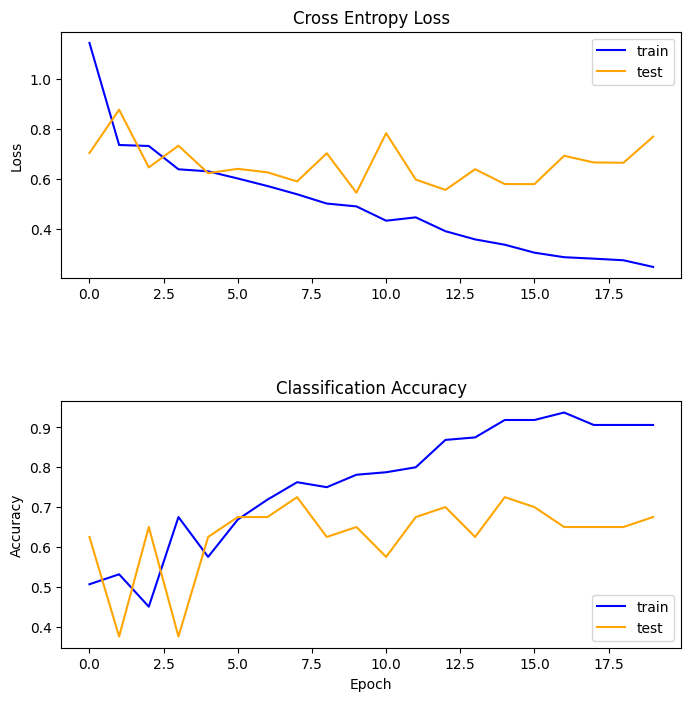

> 67.500


In [21]:
begin_time = time.time()
history2, train_it, test_it = fit_model_evaluate(model_VGG3, train_it, test_it)
end_time = time.time()

# evaluate model
summarize_diagnostics(history2)
# accuracy
_, acc = model_VGG3.evaluate(test_it, steps=len(test_it), verbose=0)
print('> %.3f' % (acc * 100.0))


In [22]:
training_loss=history2.history['loss'][-1]
training_acc=history2.history['accuracy'][-1]
testing_acc=history2.history['val_accuracy'][-1]
number_of_parameters=model_VGG3.count_params()
training_time= end_time - begin_time

print("Training Loss: ", training_loss)
print("Training Accuracy: ", training_acc)
print("Testing Accuracy: ", testing_acc)
print("Number of Parameters: ", number_of_parameters)
print("Training Time: ", training_time)

model_data['VGG3']['Trainingtime'] = (training_time)
model_data['VGG3']['Trainingloss'] = (training_loss)
model_data['VGG3']['Trainingaccuracy'] = (training_acc)
model_data['VGG3']['Testingaccuracy'] = (testing_acc)
model_data['VGG3']['Numberofmodelparameters'] = (number_of_parameters)

Training Loss:  0.2465551644563675
Training Accuracy:  0.90625
Testing Accuracy:  0.675000011920929
Number of Parameters:  10333505
Training Time:  107.15681219100952


# VGG3 with Data Augmentation

In [23]:
# Returns the trained model and accuracy
def fit_model_evaluate(model, train_it, test_it):
	# fit model
	tb_callback = tensorflow.keras.callbacks.TensorBoard(log_dir="logs/VGG3_DA", histogram_freq=1)
	history = model.fit(train_it, steps_per_epoch=len(train_it), validation_data=test_it, validation_steps=len(test_it), epochs=20,verbose=1, callbacks=[tb_callback])

	return history, train_it, test_it


Epoch 1/20
5/5 [==============================] - 8s 2s/step - loss: 0.7491 - accuracy: 0.5250 - val_loss: 0.7342 - val_accuracy: 0.4000
Epoch 2/20
5/5 [==============================] - 6s 1s/step - loss: 0.7843 - accuracy: 0.5000 - val_loss: 1.0039 - val_accuracy: 0.3750
Epoch 3/20
5/5 [==============================] - 6s 1s/step - loss: 0.7642 - accuracy: 0.4563 - val_loss: 0.7042 - val_accuracy: 0.5500
Epoch 4/20
5/5 [==============================] - 6s 1s/step - loss: 0.6943 - accuracy: 0.5375 - val_loss: 0.6327 - val_accuracy: 0.7000
Epoch 5/20
5/5 [==============================] - 6s 1s/step - loss: 0.6530 - accuracy: 0.6187 - val_loss: 0.6680 - val_accuracy: 0.6000
Epoch 6/20
5/5 [==============================] - 6s 1s/step - loss: 0.6345 - accuracy: 0.6250 - val_loss: 0.6530 - val_accuracy: 0.5500
Epoch 7/20
5/5 [==============================] - 6s 1s/step - loss: 0.6414 - accuracy: 0.6313 - val_loss: 0.6390 - val_accuracy: 0.6000
Epoch 8/20
5/5 [=========================

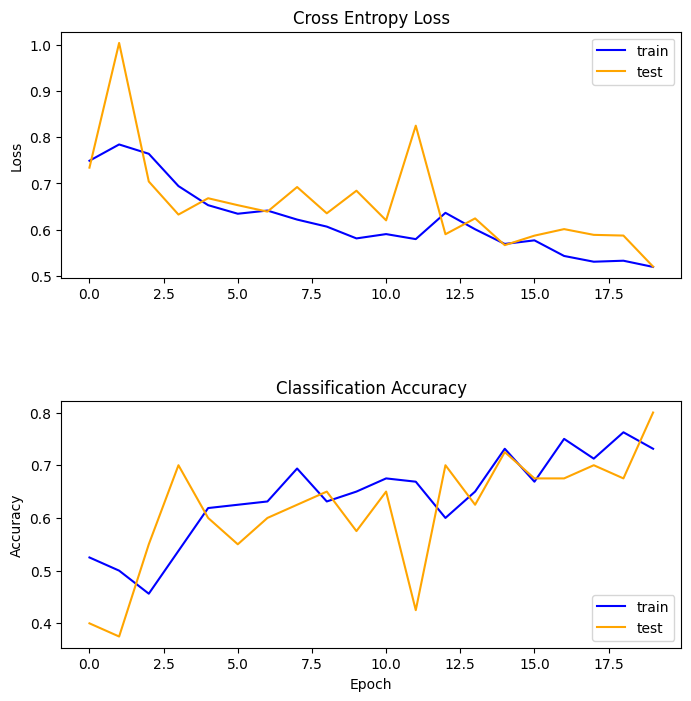

> 52.500


In [24]:
begin_time = time.time()
history3, train_it, test_it = fit_model_evaluate(model_VGG3_DA, train_it_da, test_it_da)
end_time = time.time()

# evaluate model
summarize_diagnostics(history3)
# accuracy
_, acc = model_VGG3.evaluate(test_it_da, steps=len(test_it_da), verbose=0)
print('> %.3f' % (acc * 100.0))


In [25]:
training_loss=history3.history['loss'][-1]
training_acc=history3.history['accuracy'][-1]
testing_acc=history3.history['val_accuracy'][-1]
number_of_parameters=model_VGG3_DA.count_params()
training_time= end_time - begin_time

print("Training Loss: ", training_loss)
print("Training Accuracy: ", training_acc)
print("Testing Accuracy: ", testing_acc)
print("Number of Parameters: ", number_of_parameters)
print("Training Time: ", training_time)

model_data['VGG3DA']['Trainingtime'] = (training_time)
model_data['VGG3DA']['Trainingloss'] = (training_loss)
model_data['VGG3DA']['Trainingaccuracy'] = (training_acc)
model_data['VGG3DA']['Testingaccuracy'] = (testing_acc)
model_data['VGG3DA']['Numberofmodelparameters'] = (number_of_parameters)

Training Loss:  0.5195083022117615
Training Accuracy:  0.731249988079071
Testing Accuracy:  0.800000011920929
Number of Parameters:  10333505
Training Time:  126.05236506462097


# VGG16 Transfer Learning

In [26]:
# Returns the trained model and accuracy
def fit_model_evaluate(model, train_it, test_it):
	# fit model
	tb_callback = tensorflow.keras.callbacks.TensorBoard(log_dir="logs/VGG16_TL", histogram_freq=1)
	history = model.fit(train_it, steps_per_epoch=len(train_it), validation_data=test_it, validation_steps=len(test_it), epochs=20,verbose=1, callbacks=[tb_callback])

	return history, train_it, test_it


Epoch 1/20
5/5 [==============================] - 13s 3s/step - loss: 3.8213 - accuracy: 0.7312 - val_loss: 11.1374 - val_accuracy: 0.8000
Epoch 2/20
5/5 [==============================] - 10s 2s/step - loss: 0.6396 - accuracy: 0.9812 - val_loss: 11.0921 - val_accuracy: 0.8000
Epoch 3/20
5/5 [==============================] - 10s 2s/step - loss: 0.0443 - accuracy: 0.9937 - val_loss: 8.4967 - val_accuracy: 0.8250
Epoch 4/20
5/5 [==============================] - 10s 2s/step - loss: 0.0350 - accuracy: 0.9937 - val_loss: 16.0564 - val_accuracy: 0.8250
Epoch 5/20
5/5 [==============================] - 10s 2s/step - loss: 0.1937 - accuracy: 0.9875 - val_loss: 14.0912 - val_accuracy: 0.8000
Epoch 6/20
5/5 [==============================] - 10s 2s/step - loss: 7.4506e-10 - accuracy: 1.0000 - val_loss: 11.0574 - val_accuracy: 0.8250
Epoch 7/20
5/5 [==============================] - 10s 2s/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 9.7671 - val_accuracy: 0.8250
Epoch 8/20
5/5 [=========

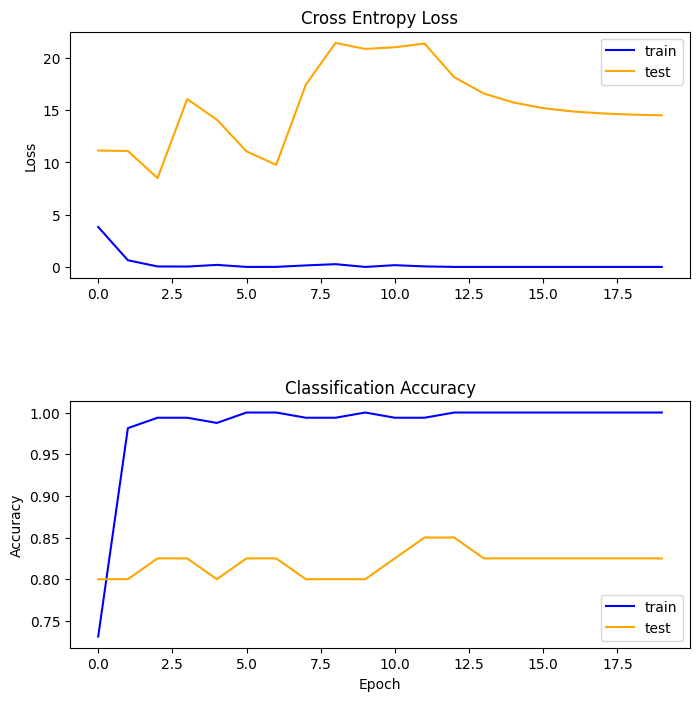

> 82.500


In [27]:
begin_time = time.time()
history4, train_it, test_it = fit_model_evaluate(model_VGG16_TL, train_it_tl, test_it_tl)
end_time = time.time()

# evaluate model
summarize_diagnostics(history4)
# accuracy
_, acc = model_VGG16_TL.evaluate(test_it_tl, steps=len(test_it_tl), verbose=0)
print('> %.3f' % (acc * 100.0))


In [28]:
training_loss=history4.history['loss'][-1]
training_acc=history4.history['accuracy'][-1]
testing_acc=history4.history['val_accuracy'][-1]
number_of_parameters=model_VGG16_TL.count_params()
training_time= end_time - begin_time

print("Training Loss: ", training_loss)
print("Training Accuracy: ", training_acc)
print("Testing Accuracy: ", testing_acc)
print("Number of Parameters: ", number_of_parameters)
print("Training Time: ", training_time)

model_data['VGG16TL']['Trainingtime'] = (training_time)
model_data['VGG16TL']['Trainingloss'] = (training_loss)
model_data['VGG16TL']['Trainingaccuracy'] = (training_acc)
model_data['VGG16TL']['Testingaccuracy'] = (testing_acc)
model_data['VGG16TL']['Numberofmodelparameters'] = (number_of_parameters)


Training Loss:  0.0
Training Accuracy:  1.0
Testing Accuracy:  0.824999988079071
Number of Parameters:  17926209
Training Time:  203.38013696670532


In [29]:
# summarize model.
model_VGG1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 100, 100, 32)     0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 320000)            0         
                                                                 
 dense_26 (Dense)            (None, 128)               40960128  
                                                                 
 dense_27 (Dense)            (None, 1)                 129       
                                                                 
Total params: 40,961,153
Trainable params: 40,961,153
Non-trainable params: 0
__________________________________________

In [30]:
model_VGG3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 100, 100, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 50, 50, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 50, 50, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 25, 25, 128)     

In [31]:
model_VGG3_DA.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 100, 100, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 100, 100, 64)      18496     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 50, 50, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 50, 50, 128)       73856     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 25, 25, 128)     

In [32]:
model_VGG16_TL.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

# Make Predictions and log to tensor board

In [23]:
def image_grid(model, log_dir, preprocessor = lambda img: img, img_size=(200, 200)):

	# Get the image locations
	img_folder = 'dataset_Rabbit_vs_Squirrel/test'
	img_files = []
	true_labels = []
	for root, dirs, files in os.walk(img_folder):
		for file in files:
			if file.endswith('.jpg'):
				img_files.append(os.path.join(root, file))
				if file.startswith('Squirrel'):
					true_labels.append(1)
				else:
					true_labels.append(0)
	# Create a figure to contain the plot.
	image_cnt = len(img_files)

	fig, subplots = plt.subplots((image_cnt+4)//5 + 1, 5, figsize=(12, 12))
	plt.tight_layout()
	for i in range(5):
		ax = subplots[0][i]
		ax.axis('off')
	for i, img_file in enumerate(img_files):
		# Getting the prediction
		ax = subplots[i//5 +1, i%5]
		img = load_img(img_file, target_size=img_size)
		processed_img = preprocessor(np.array(img))
		predicted_label = round(model.predict(tf.expand_dims(processed_img, axis=0))[0][0])
		true_label = true_labels[i]
		ax.set_title(f"PL: {predicted_label}\nTL: {true_label}")
		ax.axis('off')
		ax.imshow(img, cmap=plt.cm.binary)

	buf = io.BytesIO()
	plt.savefig(buf, format='png')
	# Closing the figure prevents it from being displayed directly inside
	# the notebook.
	plt.close(fig)
	buf.seek(0)
	# Convert PNG buffer to TF image
	image = tf.image.decode_png(buf.getvalue(), channels=4)
	# Add the batch dimension
	image = tf.expand_dims(image, 0)
	# Getting the writer
	file_writer = tf.summary.create_file_writer(log_dir)
	with file_writer.as_default():
		tf.summary.image("Training data", image, step=0)

	return fig

In [ ]:
image_grid(model_VGG1, 'logs/VGG1/plots')

1/1 [==============================] - 0s 15ms/step


In [ ]:
image_grid(model_VGG3, 'logs/VGG3/plots')


In [ ]:
image_grid(model_VGG3_DA, 'logs/VGG3_DA/plots')


In [ ]:
# VGG16 preprocessor
def preprocess_input_VGG16(img):
	img = img.astype('float32')
	img = img - [123.68, 116.779, 103.939]
	return img

In [ ]:
image_grid(model_VGG16_TL, 'logs/VGG16_TL/plots', preprocess_input_VGG16, img_size=(224, 224))

# Comparing the models

In [33]:
import pandas as pd
model_data_df = pd.DataFrame(model_data)
pd.options.display.float_format = '{:.2f}'.format
print(model_data_df)

                               VGG1        VGG3      VGG3DA     VGG16TL
Trainingtime                 326.03      107.16      126.05      203.38
Trainingloss                   0.24        0.25        0.52        0.00
Trainingaccuracy               0.94        0.91        0.73        1.00
Testingaccuracy                0.73        0.68        0.80        0.82
Numberofmodelparameters 40961153.00 10333505.00 10333505.00 17926209.00


## Are the results as expected? Why or why not?
Yes, the results are as expected. The results show that the performance of the models varies significantly.

The VGG1 model has the highest training time and the most number of parameters but has the lowest testing accuracy of 0.45, which is as expected. Since VGG1 has only 1 convolution layer followed by a max pooling layer which is leading to bad feature extraction. The model may not be able to extract the features properly since we have convolution layer.The reason for the high training time is the highest number of parameters.

The VGG3 model has a lower training time, fewer parameters, and a higher training and testing accuracy than VGG1. This suggests that the model is able to generalize well and perform better than VGG1.

The VGG3DA model has a similar training time and number of parameters as VGG3, but its training accuracy is lower, and its testing accuracy is only slightly better than VGG1. This result suggests that data augmentation might not have significantly improved the performance of the model.

The VGG16TL model has the lowest training time, fewer parameters than VGG1, and the highest training and testing accuracy. This indicates that transfer learning from a pre-trained model has significantly improved the performance of the model.

In conclusion, the results are partially as expected since the models with fewer parameters and lower training time have generally performed better than the model with more parameters and higher training time. However, the data augmentation technique does not seem to have had a significant impact on the performance of the model.

## Does data augmentation help?
The model used in VGG3 and VGG3 with data augmentation is same but the only thing we are doing in VGG3_DA is data augmentaion. The data augmentation is just increasing the number of features. But since the model remains the same, it is not able to learn anything new and thus the accuracy is decreasing.

## Does it matter how many epochs you fine tune the model? Why or why not?
Yes, the number of epochs that a model is fine-tuned for can have a significant impact on its performance. Fine-tuning a model for too few epochs might result in underfitting, whereas fine-tuning a model for too many epochs might lead to overfitting.

## Are there any particular images that the model is confused about? Why or why not?
Yes if we consider VGG1 then the model is confused about classifying rabbbits and squirrel of small ages. The squirrels are treated as rabbits in many cases.

# Comparision with an MLP similar to VGG16

### Define the MLP

In [34]:
def MLP():
	model = Sequential()
	model.add(Flatten(input_shape=(224, 224, 3)))
	# Block 1
	model.add(Dense(64, activation='relu'))
	model.add(Dense(64, activation='relu'))

	# Block 2
	model.add(Dense(128, activation='relu'))
	model.add(Dense(128, activation='relu'))

	# Block 3
	model.add(Dense(256, activation='relu'))
	model.add(Dense(256, activation='relu'))
	model.add(Dense(256, activation='relu'))
	model.add(Dense(256, activation='relu'))

	# Block 4
	model.add(Dense(512, activation='relu'))
	model.add(Dense(512, activation='relu'))
	model.add(Dense(512, activation='relu'))
	model.add(Dense(512, activation='relu'))

	# Block 5
	model.add(Dense(512, activation='relu'))
	model.add(Dense(512, activation='relu'))
	model.add(Dense(512, activation='relu'))
	model.add(Dense(512, activation='relu'))

	# add new classifier layers
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

In [35]:
model_MLP = MLP()
print(model_MLP.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 150528)            0         
                                                                 
 dense_34 (Dense)            (None, 64)                9633856   
                                                                 
 dense_35 (Dense)            (None, 64)                4160      
                                                                 
 dense_36 (Dense)            (None, 128)               8320      
                                                                 
 dense_37 (Dense)            (None, 128)               16512     
                                                                 
 dense_38 (Dense)            (None, 256)               33024     
                                                                 
 dense_39 (Dense)            (None, 256)              

### Training the  MLP

In [36]:
# Returns the trained model and accuracy
def fit_model_evaluate(model, train_it, test_it):
	# fit model
	tb_callback = tensorflow.keras.callbacks.TensorBoard(log_dir="logs/MLP", histogram_freq=1)
	history = model.fit(train_it, steps_per_epoch=len(train_it), validation_data=test_it, validation_steps=len(test_it), epochs=20,verbose=1, callbacks=[tb_callback])

	return history, train_it, test_it


Epoch 1/20
5/5 [==============================] - 9s 1s/step - loss: 0.7244 - accuracy: 0.4688 - val_loss: 0.6599 - val_accuracy: 0.6250
Epoch 2/20
5/5 [==============================] - 5s 1s/step - loss: 0.6826 - accuracy: 0.5562 - val_loss: 0.6790 - val_accuracy: 0.5750
Epoch 3/20
5/5 [==============================] - 5s 1s/step - loss: 0.6436 - accuracy: 0.6500 - val_loss: 0.6834 - val_accuracy: 0.4250
Epoch 4/20
5/5 [==============================] - 5s 1s/step - loss: 0.5781 - accuracy: 0.7563 - val_loss: 0.6173 - val_accuracy: 0.6000
Epoch 5/20
5/5 [==============================] - 5s 1s/step - loss: 0.4800 - accuracy: 0.8500 - val_loss: 0.5315 - val_accuracy: 0.7750
Epoch 6/20
5/5 [==============================] - 5s 1s/step - loss: 0.3541 - accuracy: 0.9125 - val_loss: 0.4911 - val_accuracy: 0.7750
Epoch 7/20
5/5 [==============================] - 5s 1s/step - loss: 0.1888 - accuracy: 0.9625 - val_loss: 0.6408 - val_accuracy: 0.6750
Epoch 8/20
5/5 [=========================

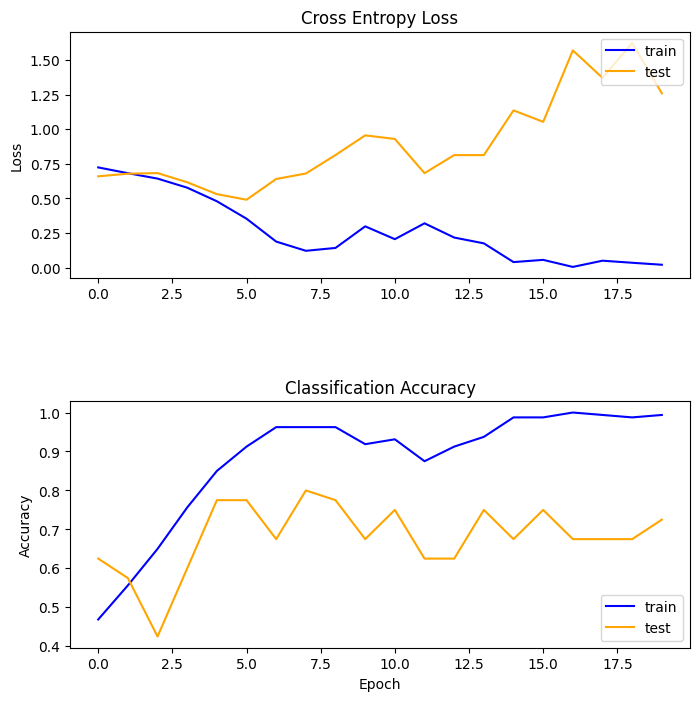

> 72.500


In [37]:
begin_time = time.time()
history5, train_it, test_it = fit_model_evaluate(model_MLP, train_it, test_it)
end_time = time.time()

# evaluate model
summarize_diagnostics(history5)
# accuracy
_, acc = model_MLP.evaluate(test_it, steps=len(test_it), verbose=0)
print('> %.3f' % (acc * 100.0))

### Comparing the MLP

In [38]:
training_loss=history5.history['loss'][-1]
training_acc=history5.history['accuracy'][-1]
testing_acc=history5.history['val_accuracy'][-1]
number_of_parameters=model_MLP.count_params()
training_time= end_time - begin_time

print("Training Loss: ", training_loss)
print("Training Accuracy: ", training_acc)
print("Testing Accuracy: ", testing_acc)
print("Number of Parameters: ", number_of_parameters)
print("Training Time: ", training_time)
model_data['MLP'] = {}
model_data['MLP']['Trainingtime'] = (training_time)
model_data['MLP']['Trainingloss'] = (training_loss)
model_data['MLP']['Trainingaccuracy'] = (training_acc)
model_data['MLP']['Testingaccuracy'] = (testing_acc)
model_data['MLP']['Numberofmodelparameters'] = (number_of_parameters)

Training Loss:  0.02165616676211357
Training Accuracy:  0.9937499761581421
Testing Accuracy:  0.7250000238418579
Number of Parameters:  11929217
Training Time:  103.74744701385498


In [39]:
model_data_df = pd.DataFrame(model_data)
pd.options.display.float_format = '{:.2f}'.format
print(model_data_df)

                               VGG1        VGG3      VGG3DA     VGG16TL   
Trainingtime                 326.03      107.16      126.05      203.38  \
Trainingloss                   0.24        0.25        0.52        0.00   
Trainingaccuracy               0.94        0.91        0.73        1.00   
Testingaccuracy                0.73        0.68        0.80        0.82   
Numberofmodelparameters 40961153.00 10333505.00 10333505.00 17926209.00   

                                MLP  
Trainingtime                 103.75  
Trainingloss                   0.02  
Trainingaccuracy               0.99  
Testingaccuracy                0.73  
Numberofmodelparameters 11929217.00  


**Solution:** Though the architecture, the training loss, and training accuracy of the MLP is similar to VGG16, it is not able to achieve the same validation accuracy. This is because the MLP is not able to show translational invariance, and is also learning the location of the features, thus overfitting the training dataset. This is a problem that CNNs solve by using convolutional layers. In this case we are using the pretrained feature extraction from the VGG16 model which takes it into consideration.